In [98]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd

In [99]:
parser = Sbopen()
games_df = parser.match(competition_id=2,season_id=27)

match_ids = games_df['match_id'].to_list()
len(match_ids)

380

In [100]:
# finding danger passes for every team in the league

team_danger_passes = {}

for idx in match_ids:
    df = parser.event(idx)[0]

    teams = df['team_name'].unique()

    for team in teams:
        for period in [1,2]:
            pass_mask = (df.team_name==team)&(df.type_name=='Pass')&(df.outcome_name.isnull())&(df.period==period)&(df.sub_type_name.isnull())
            team_passes = df[pass_mask][['x','y','end_x','end_y','minute','second','player_name','team_name']]
    
    
            shot_mask = (df.type_name=='Shot')&(df.period==period)&(df.team_name==team)
            team_shots = df[shot_mask][['minute','second','team_name']]
            
            shot_times = team_shots['minute']*60+team_shots['second']
            shot_window = 15

            shot_start = shot_times - shot_window
            shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)

            pass_times = team_passes['minute']*60+team_passes['second']
            pass_to_shot = pass_times.apply(lambda x: True in ((shot_start<x)&(x<shot_times)).unique())

            danger_passes = team_passes[pass_to_shot]

            if not danger_passes.empty:
                if team not in team_danger_passes:
                    team_danger_passes[team] = [danger_passes]
                else:
                    team_danger_passes[team].append(danger_passes)

for team in team_danger_passes:
    team_danger_passes[team] = pd.concat(team_danger_passes[team],ignore_index=True)


In [101]:
league_danger_passes = pd.concat([df.assign(team=team) for team, df in team_danger_passes.items()],
                                ignore_index=True)

league_danger_passes = league_danger_passes.drop(columns='team')
league_danger_passes.head(20)

,x,y,end_x,end_y,minute,second,player_name,team_name
0,55.5,8.9,69.8,1.2,9,6,Christian Fuchs,Leicester City
1,69.8,1.4,100.6,9.3,9,8,Marc Albrighton,Leicester City
2,101.7,1.6,89.5,9.6,9,15,N''Golo Kanté,Leicester City
3,86.9,14.5,114.3,51.3,9,17,Marc Albrighton,Leicester City
4,71.5,53.2,108.9,32.4,33,49,Riyad Mahrez,Leicester City
5,70.6,45.3,75.8,35.0,37,38,N''Golo Kanté,Leicester City
6,82.6,29.5,106.4,23.9,37,40,Riyad Mahrez,Leicester City
7,14.4,15.6,21.2,21.9,49,57,Christian Fuchs,Leicester City
8,21.2,21.9,12.8,12.4,49,58,Danny Drinkwater,Leicester City
9,18.4,6.8,42.1,5.4,50,1,Christian Fuchs,Leicester City


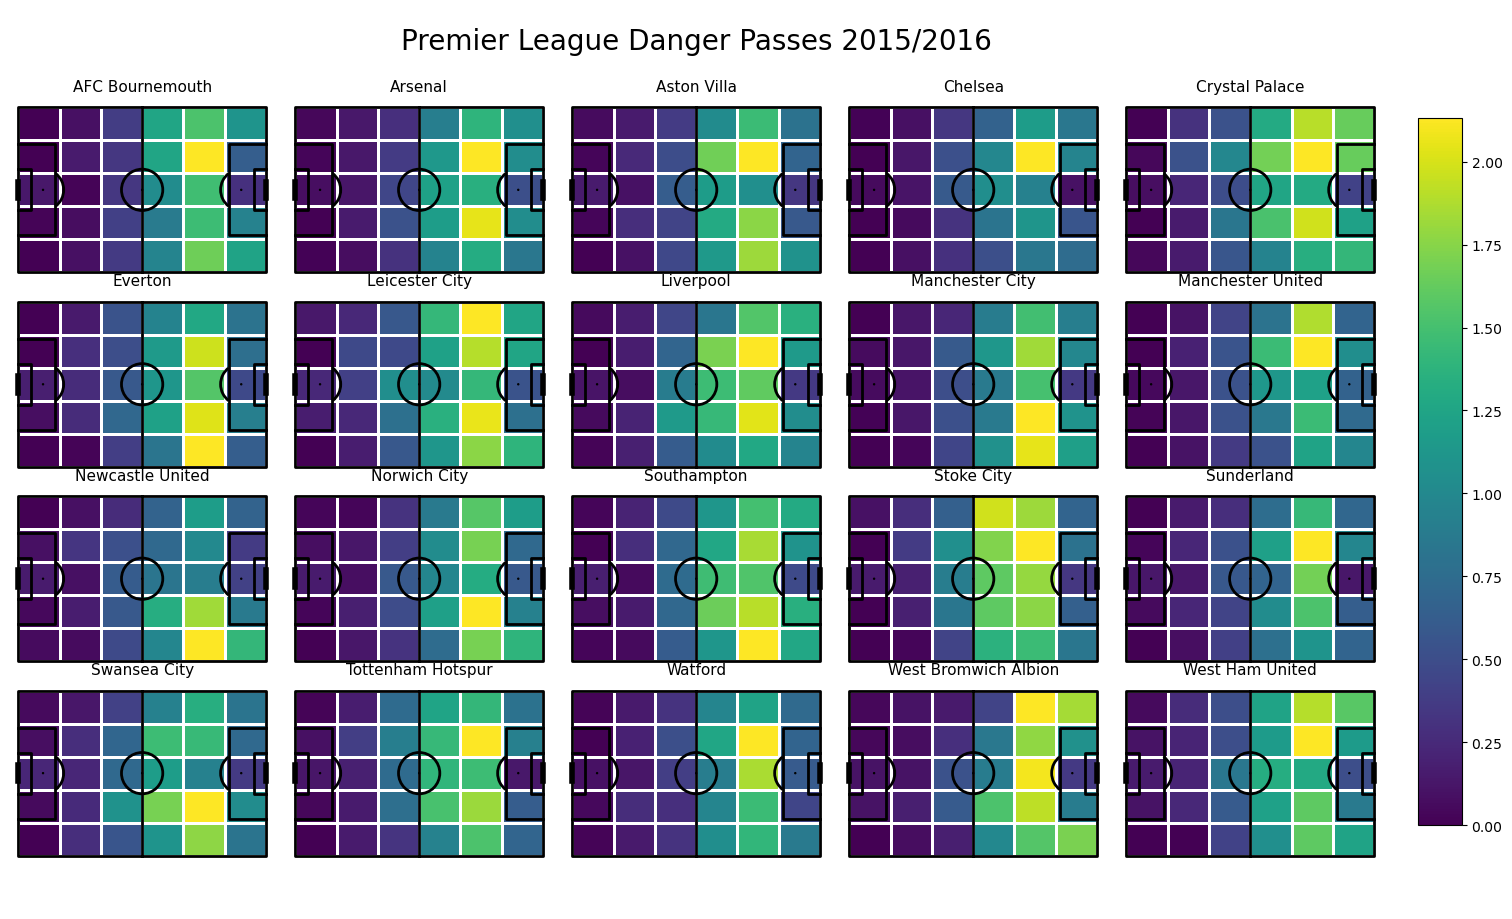

In [102]:
pitch = Pitch(line_color='black',line_zorder=2)
fig,axs = pitch.grid(ncols=5,nrows=4,grid_height=0.85,title_height=0.06,axis=False,
                    endnote_height=0.04,title_space=0.04,endnote_space=0.01)

teams = sorted(league_danger_passes.team_name.unique())

for team, ax in zip(teams, axs['pitch'].flat[:len(teams)]):
    ax.set_title(team,fontsize=11)
    team_df = league_danger_passes[league_danger_passes['team_name']==team]
    bin_statistic = pitch.bin_statistic(team_df.x,team_df.y,statistic='count',bins=(6,5),normalize=False)
    bin_statistic['statistic'] = bin_statistic['statistic']/38
    pcm = pitch.heatmap(bin_statistic,cmap='viridis',edgecolors='white',ax=ax)
    
ax_cbar = fig.add_axes((1,0.093,0.03,0.786))
cbar = plt.colorbar(pcm,cax=ax_cbar)
fig.suptitle('Premier League Danger Passes 2015/2016',fontsize=20)
plt.show()

# Kevin De Bruyne - 2015/2016 Attacking Play

In [103]:
team = 'Manchester City'
player = 'Kevin De Bruyne'

kdb_passes = pd.DataFrame()

city_ids = games_df[(games_df['home_team_name']==team)|(games_df['away_team_name']==team)]['match_id'].to_list()

for cid in city_ids:
    city = parser.event(cid)[0]

    kev_mask = (city.team_name==team)&(city.player_name==player)&(city.type_name=='Pass')&(city.outcome_name.isnull())&(city.sub_type_name.isnull())
    kev_passes = city[kev_mask][['match_id','x','y','end_x','end_y','player_name']]
    kdb_passes = pd.concat([kdb_passes,kev_passes],ignore_index=True)
    

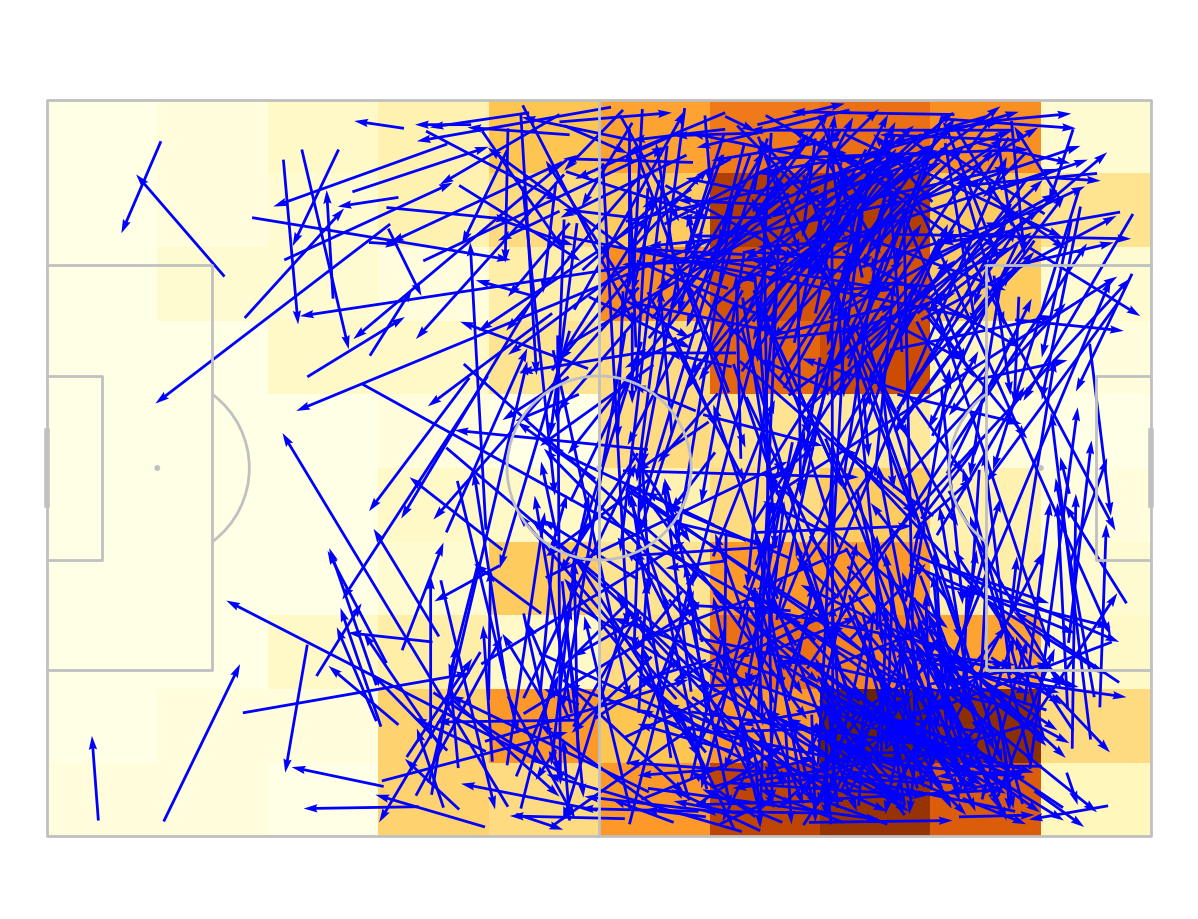

In [104]:
games_played = len(kdb_passes.match_id.unique())

pitch = Pitch(line_zorder=2,line_color='silver')
fig,ax = pitch.grid(grid_height=0.9,title_height=0.06,axis=False,endnote_height=0.04,
                   title_space=0,endnote_space=0)

bin_statistic = pitch.bin_statistic(kdb_passes.x,kdb_passes.y,statistic='count',bins=(10,10),normalize=False)
bin_statistic['statistic'] = (bin_statistic['statistic']/games_played)*90

pcm = pitch.heatmap(bin_statistic,cmap='YlOrBr',ax=ax['pitch'])
pitch.arrows(kdb_passes.x,kdb_passes.y,kdb_passes.end_x,kdb_passes.end_y,ax=ax['pitch'],color='blue',width=2)
plt.show()

In [105]:
city[['match_id','x','y','end_x','end_y','player_name','type_name','sub_type_name','outcome_name']]

,match_id,x,y,end_x,end_y,player_name,type_name,sub_type_name,outcome_name
0,3754258,NaN,NaN,NaN,NaN,NaN,Starting XI,NaN,NaN
1,3754258,NaN,NaN,NaN,NaN,NaN,Starting XI,NaN,NaN
2,3754258,NaN,NaN,NaN,NaN,NaN,Half Start,NaN,NaN
3,3754258,NaN,NaN,NaN,NaN,NaN,Half Start,NaN,NaN
4,3754258,89.3,74.8,NaN,NaN,Jesús Navas González,Ball Receipt,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3667,3754258,75.2,8.0,74.8,21.8,Rudy Gestede,Carry,NaN,NaN
3668,3754258,74.8,21.8,69.0,30.5,Rudy Gestede,Pass,NaN,NaN
3669,3754258,NaN,NaN,NaN,NaN,NaN,Half End,NaN,NaN
3670,3754258,NaN,NaN,NaN,NaN,NaN,Half End,NaN,NaN


In [106]:
kdb_passes['dx'] = kdb_passes['end_x'] - kdb_passes['x']
kdb_passes['dy'] = kdb_passes['end_y'] - kdb_passes['y']
avg_vectors = kdb_passes.groupby('player_name')[['dx', 'dy']].mean().reset_index()

avg_vectors

,player_name,dx,dy
0,Kevin De Bruyne,1.506407,0.180025


# Radar charts for scouting

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import pathlib
import warnings
import soccerdata as sd
from scipy import stats
from mplsoccer import PyPizza, FontManager, add_image
from pandasql import sqldf
from PIL import Image #to import images

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

[08/12/25 12:08:10] INFO     No custom team name replacements found. You can configure these in       ]8;id=188685;file://c:\Users\elvin\anaconda3\envs\myenv\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=982148;file://c:\Users\elvin\anaconda3\envs\myenv\lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\elvin\soccerdata\config\teamname_replacements.json.                          

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=266246;file://c:\Users\elvin\anaconda3\envs\myenv\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=390669;file://c:\Users\elvin\anaconda3\envs\myenv\lib\site-packages\soccerdata\_config.py#197\197]8;;\
                             C:\Users\elvin\soccerdata\config\league_dict.json.                                    

In [2]:
fbref = sd.FBref('ENG-Premier League','2023',proxy='tor')
player_standard_stats = fbref.read_player_season_stats('standard').reset_index()
player_defense_stats = fbref.read_player_season_stats('defense').reset_index()
player_shooting_stats = fbref.read_player_season_stats('shooting').reset_index()
player_passing_stats = fbref.read_player_season_stats('passing').reset_index()
player_ptypes_stats = fbref.read_player_season_stats('passing_types').reset_index()
player_possession_stats = fbref.read_player_season_stats('possession').reset_index()
player_misc_stats = fbref.read_player_season_stats('misc').reset_index()

[08/12/25 12:08:11] INFO     Saving cached data to C:\Users\elvin\soccerdata\data\FBref              ]8;id=903210;file://c:\Users\elvin\anaconda3\envs\myenv\lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=595855;file://c:\Users\elvin\anaconda3\envs\myenv\lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [3]:
player_standard_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in player_standard_stats.columns]
player_defense_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in player_defense_stats.columns]
player_shooting_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in player_shooting_stats.columns]
player_passing_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in player_passing_stats.columns]
player_ptypes_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in player_ptypes_stats.columns]
player_possession_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in player_possession_stats.columns]
player_misc_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in player_misc_stats.columns]

In [4]:
player_possession_stats.columns

Index(['league_', 'season_', 'team_', 'player_', 'nation_', 'pos_', 'age_',
       'born_', '90s_', 'Touches_Touches', 'Touches_Def Pen',
       'Touches_Def 3rd', 'Touches_Mid 3rd', 'Touches_Att 3rd',
       'Touches_Att Pen', 'Touches_Live', 'Take-Ons_Att', 'Take-Ons_Succ',
       'Take-Ons_Succ%', 'Take-Ons_Tkld', 'Take-Ons_Tkld%', 'Carries_Carries',
       'Carries_TotDist', 'Carries_PrgDist', 'Carries_PrgC', 'Carries_1/3',
       'Carries_CPA', 'Carries_Mis', 'Carries_Dis', 'Receiving_Rec',
       'Receiving_PrgR'],
      dtype='object')

In [5]:
#getting latent varaibles

shots_taken = player_shooting_stats[['team_','player_','Standard_Sh']]
Finishing = player_standard_stats[['team_','player_','pos_','Playing Time_90s','Playing Time_Min','Performance_Gls','Expected_xG']]
Finishing = Finishing.merge(shots_taken, on=['team_','player_'], how='left')
Finishing['G-xG'] = Finishing['Performance_Gls'] - Finishing['Expected_xG']
Finishing['S2G'] = np.where(Finishing['Standard_Sh'] > 0 ,
                            Finishing['Performance_Gls']/Finishing['Standard_Sh'], 0)


Chance_creation = player_passing_stats[['team_','player_','pos_','90s_','Ast_','KP_','1/3_']]
ct = player_ptypes_stats[['team_','player_','Pass Types_TB', 'Pass Types_Crs']]
Chance_creation = Chance_creation.merge(ct, on=['team_','player_'], how='left')


In_possession = player_possession_stats[['team_','player_','90s_','Take-Ons_Succ','Carries_PrgC','Carries_Dis']]
pp = player_standard_stats[['team_','player_','Progression_PrgP']]
In_possession = In_possession.merge(pp,on=['team_','player_'],how='left')
pass_comp = player_passing_stats[['team_','player_','Total_Cmp%']]
In_possession = In_possession.merge(pass_comp,on=['team_','player_'],how='left')

Defending = player_defense_stats[['team_','player_','pos_','90s_','Int_','Tackles_TklW','Blocks_Sh']]
rad = player_misc_stats[['team_','player_','Performance_Recov','Aerial Duels_Won%']]
Defending = Defending.merge(rad,on=['team_','player_'],how='left')


In [6]:
#renaming columns
Finishing.rename(columns={'team_':'team',
                          'player_':'player',
                          'pos_':'position',
                          'Playing Time_90s':'90s',
                          'Playing Time_Min':'mins_played',
                          'Performance_Gls':'goals_scored',
                          'Expected_xG':'xG',
                          'Standard_Sh':'shots_played',
                          'S2G':'conversion_rate'
                          },inplace=True)

Chance_creation.rename(columns={'team_':'team',
                                'player_':'player',
                                'pos_':'position',
                                '90s_':'90s',
                                'Ast_':'assists',
                                'KP_':'key_passes',
                                '1/3_':'passes_into_final_third',
                                'Pass Types_TB':'through_balls',
                                'Pass Types_Crs':'crosses'
                                },inplace=True)

In_possession.rename(columns={'team_':'team',
                                'player_':'player',
                                'pos_':'position',
                                '90s_':'90s',
                                'Poss':'avg_possession',
                                'Take-Ons_Succ':'successful_take-ons',
                                'Carries_PrgC':'progressive_carries',
                                'Carries_Dis':'dispossessed',
                                'Progression_PrgP':'progressive_passes',
                                'Total_Cmp%':'%passes_completed'},inplace=True)

Defending.rename(columns={'team_':'team',
                            'player_':'player',
                            'pos_':'position',
                            '90s_':'90s',
                            'Int_':'interceptions',
                            'Tackles_TklW':'tackles_won',
                            'Blocks_Sh':'shots_blocked',
                            'Performance_Recov':'recoveries',
                            'Aerial Duels_Won%':"%_aerial_duels_won"
                            },inplace=True)

In [7]:
#filtering for players with at least 5 games played in the league
Finishing = Finishing[Finishing['90s']>=5]
Chance_creation = Chance_creation[Chance_creation['90s']>=5]
In_possession = In_possession[In_possession['90s']>=5]
Defending = Defending[Defending['90s']>=5]


In [8]:
In_possession.columns

Index(['team', 'player', '90s', 'successful_take-ons', 'progressive_carries',
       'dispossessed', 'progressive_passes', '%passes_completed'],
      dtype='object')

In [ ]:
finishing_metrics = ['goals_scored','xG','G-xG','conversion_rate']
Finishing = Finishing.dropna(subset=finishing_metrics)

for col in finishing_metrics:
    Finishing[f'{col}_scaled'] = (Finishing[col] - Finishing[col].min()) / (Finishing[col].max() - Finishing[col].min())

Finishing['clinical_score'] = (0.35 * Finishing['goals_scored_scaled'] + 
                               0.25 * Finishing['G-xG_scaled'] + 
                               0.25 * Finishing['conversion_rate_scaled'] +
                               0.15 * Finishing['xG_scaled'])

Finishing['clinical_score'] *= 100

cc_metrics = {'assists':0.35, 'key_passes':0.25, 'passes_into_final_third':0.15, 'through_balls':0.1, 'crosses':0.15}

Chance_creation['creative_score'] = 0

for metric,weight in cc_metrics.items():
    Chance_creation[metric+'_scaled'] = (Chance_creation[metric] - Chance_creation[metric].min())/ (Chance_creation[metric].max() - Chance_creation[metric].min())

    Chance_creation['creative_score'] += weight* Chance_creation[metric+'_scaled']

Chance_creation['creative_score'] *= 100



br_metrics = {'successful_take-ons':0.2, 'progressive_carries':0.25, 'dispossessed':-0.2, 'progressive_passes':0.25, '%passes_completed':0.3}

In_possession['retention_score'] = 0

for metric,weight in br_metrics.items():
    In_possession[metric+'_scaled'] = (In_possession[metric] - In_possession[metric].min())/ (In_possession[metric].max() - In_possession[metric].min())

    In_possession['retention_score'] += weight* In_possession[metric+'_scaled']

min_score = In_possession['retention_score'].min()
max_score = In_possession['retention_score'].max()

In_possession['retention_score'] = (
    (In_possession['retention_score'] - min_score) /
    (max_score - min_score)
) * (100 - 1) + 1

KeyError: 'dispossed'

In [ ]:
Chance_creation

,team,player,position,90s,assists,key_passes,1/3_,through_balls,crosses,creative_score,assists_scaled,key_passes_scaled
0,Arsenal,Aaron Ramsdale,GK,6.0,0,0,4,0,0,0.0,0.0,0.0
1,Arsenal,Ben White,DF,33.2,4,38,172,5,57,0.191026,0.307692,0.333333
2,Arsenal,Bukayo Saka,FW,32.4,9,91,39,4,181,0.441869,0.692308,0.798246
4,Arsenal,David Raya,GK,32.0,0,0,30,0,0,0.0,0.0,0.0
5,Arsenal,Declan Rice,MF,35.8,8,47,240,2,60,0.318455,0.615385,0.412281
...,...,...,...,...,...,...,...,...,...,...,...,...
573,Wolves,Pedro Neto,"FW,MF",16.8,9,38,23,1,115,0.325641,0.692308,0.333333
574,Wolves,Rayan Aït-Nouri,"DF,MF",25.9,1,25,60,2,41,0.081748,0.076923,0.219298
575,Wolves,Santiago Bueno,DF,9.1,0,2,16,0,2,0.004386,0.0,0.017544
578,Wolves,Tommy Doyle,MF,13.6,0,8,86,2,28,0.017544,0.0,0.070175


In [10]:
poss = fbref.read_team_season_stats('possession').reset_index()

poss.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in poss.columns]

poss = poss[['team_','Poss_']]

In [11]:
poss

,team_,Poss_
0,Arsenal,58.2
1,Aston Villa,53.1
2,Bournemouth,44.4
3,Brentford,45.2
4,Brighton,59.8
5,Burnley,47.4
6,Chelsea,58.6
7,Crystal Palace,42.3
8,Everton,40.8
9,Fulham,50.6
